# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [64]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [65]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> dict[str, List[int]]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        item = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return item

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> (
        dict)[str, torch.Tensor]:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [66]:
np.random.seed(42)
# train_idx = np.random.choice(np.arange(len(dataset['train'])), 5000)
# train_dataset = WordDataset(dataset['train'].select(train_idx))
train_dataset = WordDataset(dataset['train'])

test_idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
test_dataset = WordDataset(dataset['test'].select(test_idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [67]:
def evaluate(model, criterion, epoch, dataloader) -> (float, float):
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        # for batch in tqdm(dataloader, desc=f'Validating epoch {epoch}:'):
        for batch in dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()
    loss = criterion(logits, batch['label'])

    return accuracy, loss

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

Возьмем модель с семинара и добавим еще выбор типа RNN.

In [68]:
class CharLM(nn.Module):
    def __init__(
            self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
            aggregation_type: str = 'max',
            dropout_part = 0.1,
            rec_layers = 1,
            rnn_type: str = 'rnn'
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        if rnn_type == 'rnn':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)
        else: #'lstm'
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_part)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [69]:
import copy
DATA_MODES = ['train', 'val', 'test']

Функция, производящая обучение данной модели. Возвращает (best_model, losses, accuracies).
Модель считается обученной, если прошло epochs итераций или некоторое время качество модели не улучшается.
freeze_threshold - порог, такой что, если accuracy на val изменилось не больше чем на этот порог, то считается, что данный шаг обучения не улучшил качество модели.
freeze_max_number - требуемое количество шагов без улучшения качества модели, чтобы считать, что модель обучена.

In [70]:
def train_model(model, criterion, optimizer, lr_scheduler, train_loader, val_loader, epochs=15, freeze_threshold=0.005, freeze_max_number=2):
    dataloaders = {'train': train_loader, 'val': val_loader}

    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    best_model_wts = model.state_dict()
    best_accuracy = 0
    best_loss = 100000000
    num_freeze = 0

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        for data_mode in DATA_MODES[:2]:
            if data_mode == 'train':
                model.train()
            else:
                model.eval()

            data_size = 0
            running_accuracy = 0
            running_loss = 0

            if data_mode == 'train':
                #for batch in tqdm(dataloaders[data_mode], desc=f'Training epoch {epoch}:'):
                for batch in dataloaders[data_mode]:
                    X = batch['input_ids'].to(device)
                    y = batch['label'].to(device)
                    optimizer.zero_grad()

                    logits = model(X)
                    loss = criterion(logits, y)
                    loss.backward()
                    optimizer.step()

                    preds = torch.argmax(logits, dim=1)
                    running_accuracy += (preds == y).float().sum().item()
                    running_loss += loss.item() * X.size(0)
                    data_size += X.size(0)

                epoch_accuracy = running_accuracy / data_size
                epoch_loss = running_loss / data_size
            else:
                epoch_accuracy, epoch_loss = evaluate(model, criterion, epoch, dataloaders['val'])

            accuracies[data_mode].append(epoch_accuracy)
            losses[data_mode].append(epoch_loss)

            if data_mode == 'train':
                lr_scheduler.step(epoch_loss)
                print('* Train  Epoch accuracy: %f  Epoch loss: %f' % (epoch_accuracy, epoch_loss))
            else:
                print('* Val    Epoch accuracy: %f  Epoch loss: %f' % (epoch_accuracy, epoch_loss))

            # сохраняем лучшую модель
            if data_mode == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                print('Saving best model...')
                best_model_wts = copy.deepcopy(model.state_dict())

            if data_mode == 'val':
                if len(accuracies[data_mode]) > 1 and (accuracies[data_mode][-1] - accuracies[data_mode][-2] < freeze_threshold):
                    num_freeze += 1
                else:
                    num_freeze = 0

        if num_freeze == freeze_max_number:
            print('The model is trained')
            break

    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

Функция, создающая модель и все необходимое окружение с данными параметрами и производящая обучение. 
Параметры и возвращаемые сущности как у train_model.

In [71]:
def start_train(dropout_part=0.1, rec_layers=1, hidden_dim=256, epochs=5, rnn_type='rnn', freeze_threshold=0.002, freeze_max_number=2):
    model = CharLM(hidden_dim=hidden_dim, vocab_size=len(vocab), num_classes=4, aggregation_type="mean", rec_layers=rec_layers, dropout_part=dropout_part, rnn_type=rnn_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1)
    return train_model(model, criterion, optimizer, lr_scheduler, train_dataloader, test_dataloader, epochs=epochs, freeze_threshold=freeze_threshold, freeze_max_number=freeze_max_number)

Вначале подберем оптимальные hidden_dim и dropout_part.
Подбор будем производить с использованием самой простой модельки: 1 рекуррентный слой и rnn без модификаций. Кажется, что если hidden_dim и dropout_part оптимальны для рассматриваемой модели, то они так же хорошо подходят и для моделей с модифицированным rnn и с другим количеством слоев. <br> 
Идейно чем больше dropout_part, тем больше мы выкидываем информации, тем самым моделька учится выделять информацию из всех нейронов слоя, так что информация приобретает более осмысленное распределение, из-за чего улучшается общее качество. Но если перегнуть, то мы выкинем слишком много информации и на основе оставшейся не получится дать валидный ответ. Получается, чем лучше распределена информация на слое, тем больше dropout_part имеет смысл делать. А так как модифицированный rnn мощнее обычного, то, возможно, имеет смысл немного увеличить dropout_part, но будем считать, что и найденный будет хорошо подходить.<br> 
С hidden_dim аналогично: чем лучше моделька упаковывает информацию в нейронах, тем меньше hidden_dim нужен, но его тоже менять не будем.

Проверим hidden_dim = 100, 256, 1024; dropout_part = 0.1, 0.25, 0.5

In [23]:
model_rnn_1layers_100hdim_10drop, losses_rnn_1layers_100hdim_10drop, acc_rnn_1layers_100hdim_10drop = start_train(epochs=8, rec_layers=1, hidden_dim=100, dropout_part=0.1)

* Epoch 1/8
* Train  Epoch accuracy: 0.814225  Epoch loss: 0.502685
* Val    Epoch accuracy: 0.879000  Epoch loss: 0.065473
Saving best model...
* Epoch 2/8
* Train  Epoch accuracy: 0.905858  Epoch loss: 0.281696
* Val    Epoch accuracy: 0.892800  Epoch loss: 0.027999
Saving best model...
* Epoch 3/8
* Train  Epoch accuracy: 0.921192  Epoch loss: 0.231560
* Val    Epoch accuracy: 0.906800  Epoch loss: 0.039640
Saving best model...
* Epoch 4/8
* Train  Epoch accuracy: 0.930900  Epoch loss: 0.201794
* Val    Epoch accuracy: 0.896800  Epoch loss: 0.045658
* Epoch 5/8
* Train  Epoch accuracy: 0.939050  Epoch loss: 0.176833
* Val    Epoch accuracy: 0.898800  Epoch loss: 0.011498
The model is trained


In [24]:
model_rnn_1layers_256hdim_10drop, losses_rnn_1layers_256hdim_10drop, acc_rnn_1layers_256hdim_10drop = start_train(epochs=8, rec_layers=1, hidden_dim=256, dropout_part=0.1)

* Epoch 1/8
* Train  Epoch accuracy: 0.844767  Epoch loss: 0.436323
* Val    Epoch accuracy: 0.890000  Epoch loss: 0.025705
Saving best model...
* Epoch 2/8
* Train  Epoch accuracy: 0.913067  Epoch loss: 0.259698
* Val    Epoch accuracy: 0.899200  Epoch loss: 0.024510
Saving best model...
* Epoch 3/8
* Train  Epoch accuracy: 0.927017  Epoch loss: 0.215582
* Val    Epoch accuracy: 0.903200  Epoch loss: 0.023883
Saving best model...
* Epoch 4/8
* Train  Epoch accuracy: 0.936775  Epoch loss: 0.184776
* Val    Epoch accuracy: 0.906400  Epoch loss: 0.027939
Saving best model...
* Epoch 5/8
* Train  Epoch accuracy: 0.943667  Epoch loss: 0.161705
* Val    Epoch accuracy: 0.905800  Epoch loss: 0.030998
* Epoch 6/8
* Train  Epoch accuracy: 0.950492  Epoch loss: 0.142417
* Val    Epoch accuracy: 0.906400  Epoch loss: 0.005516
The model is trained


In [25]:
model_rnn_1layers_1024hdim_10drop, losses_rnn_1layers_1024hdim_10drop, acc_rnn_1layers_1024hdim_10drop = start_train(epochs=8, rec_layers=1, hidden_dim=1024, dropout_part=0.1)

* Epoch 1/8
* Train  Epoch accuracy: 0.847242  Epoch loss: 0.435203
* Val    Epoch accuracy: 0.892400  Epoch loss: 0.056347
Saving best model...
* Epoch 2/8
* Train  Epoch accuracy: 0.904950  Epoch loss: 0.291853
* Val    Epoch accuracy: 0.890000  Epoch loss: 0.034173
* Epoch 3/8
* Train  Epoch accuracy: 0.916450  Epoch loss: 0.256303
* Val    Epoch accuracy: 0.905000  Epoch loss: 0.023016
Saving best model...
* Epoch 4/8
* Train  Epoch accuracy: 0.922858  Epoch loss: 0.235467
* Val    Epoch accuracy: 0.904400  Epoch loss: 0.006318
* Epoch 5/8
* Train  Epoch accuracy: 0.926400  Epoch loss: 0.222069
* Val    Epoch accuracy: 0.886200  Epoch loss: 0.009959
The model is trained


In [26]:
model_rnn_1layers_100hdim_25drop, losses_rnn_1layers_100hdim_25drop, acc_rnn_1layers_100hdim_25drop = start_train(epochs=8, rec_layers=1, hidden_dim=100, dropout_part=0.25)

* Epoch 1/8
* Train  Epoch accuracy: 0.816992  Epoch loss: 0.496041
* Val    Epoch accuracy: 0.877600  Epoch loss: 0.027258
Saving best model...
* Epoch 2/8
* Train  Epoch accuracy: 0.906933  Epoch loss: 0.281280
* Val    Epoch accuracy: 0.899800  Epoch loss: 0.016459
Saving best model...
* Epoch 3/8
* Train  Epoch accuracy: 0.921883  Epoch loss: 0.234206
* Val    Epoch accuracy: 0.906400  Epoch loss: 0.009148
Saving best model...
* Epoch 4/8
* Train  Epoch accuracy: 0.931017  Epoch loss: 0.204908
* Val    Epoch accuracy: 0.906200  Epoch loss: 0.021180
* Epoch 5/8
* Train  Epoch accuracy: 0.939100  Epoch loss: 0.180809
* Val    Epoch accuracy: 0.906200  Epoch loss: 0.003417
The model is trained


In [27]:
model_rnn_1layers_256hdim_25drop, losses_rnn_1layers_256hdim_25drop, acc_rnn_1layers_256hdim_25drop = start_train(epochs=8, rec_layers=1, hidden_dim=256, dropout_part=0.25)

* Epoch 1/8
* Train  Epoch accuracy: 0.839933  Epoch loss: 0.444519
* Val    Epoch accuracy: 0.900000  Epoch loss: 0.013809
Saving best model...
* Epoch 2/8
* Train  Epoch accuracy: 0.911925  Epoch loss: 0.263941
* Val    Epoch accuracy: 0.905200  Epoch loss: 0.007807
Saving best model...
* Epoch 3/8
* Train  Epoch accuracy: 0.925300  Epoch loss: 0.220004
* Val    Epoch accuracy: 0.906200  Epoch loss: 0.006594
Saving best model...
* Epoch 4/8
* Train  Epoch accuracy: 0.934842  Epoch loss: 0.191027
* Val    Epoch accuracy: 0.902000  Epoch loss: 0.003444
The model is trained


In [28]:
model_rnn_1layers_1024hdim_25drop, losses_rnn_1layers_1024hdim_25drop, acc_rnn_1layers_1024hdim_25drop = start_train(epochs=8, rec_layers=1, hidden_dim=1024, dropout_part=0.25)

* Epoch 1/8
* Train  Epoch accuracy: 0.818067  Epoch loss: 0.508204
* Val    Epoch accuracy: 0.862000  Epoch loss: 0.007408
Saving best model...
* Epoch 2/8
* Train  Epoch accuracy: 0.890325  Epoch loss: 0.342004
* Val    Epoch accuracy: 0.889800  Epoch loss: 0.009313
Saving best model...
* Epoch 3/8
* Train  Epoch accuracy: 0.897792  Epoch loss: 0.314246
* Val    Epoch accuracy: 0.897800  Epoch loss: 0.015600
Saving best model...
* Epoch 4/8
* Train  Epoch accuracy: 0.910092  Epoch loss: 0.276011
* Val    Epoch accuracy: 0.897800  Epoch loss: 0.014430
* Epoch 5/8
* Train  Epoch accuracy: 0.916433  Epoch loss: 0.259265
* Val    Epoch accuracy: 0.900600  Epoch loss: 0.150291
Saving best model...
* Epoch 6/8
* Train  Epoch accuracy: 0.918400  Epoch loss: 0.252438
* Val    Epoch accuracy: 0.885000  Epoch loss: 0.011049
* Epoch 7/8
* Train  Epoch accuracy: 0.922717  Epoch loss: 0.238283
* Val    Epoch accuracy: 0.891800  Epoch loss: 0.085949
* Epoch 8/8
* Train  Epoch accuracy: 0.923250  E

In [29]:
model_rnn_1layers_100hdim_50drop, losses_rnn_1layers_100hdim_50drop, acc_rnn_1layers_100hdim_50drop = start_train(epochs=8, rec_layers=1, hidden_dim=100, dropout_part=0.5)

* Epoch 1/8
* Train  Epoch accuracy: 0.815783  Epoch loss: 0.499799
* Val    Epoch accuracy: 0.890800  Epoch loss: 0.005588
Saving best model...
* Epoch 2/8
* Train  Epoch accuracy: 0.905875  Epoch loss: 0.289788
* Val    Epoch accuracy: 0.906400  Epoch loss: 0.009302
Saving best model...
* Epoch 3/8
* Train  Epoch accuracy: 0.920308  Epoch loss: 0.244766
* Val    Epoch accuracy: 0.903600  Epoch loss: 0.003801
* Epoch 4/8
* Train  Epoch accuracy: 0.930242  Epoch loss: 0.214977
* Val    Epoch accuracy: 0.906600  Epoch loss: 0.001697
Saving best model...
* Epoch 5/8
* Train  Epoch accuracy: 0.937967  Epoch loss: 0.191820
* Val    Epoch accuracy: 0.910600  Epoch loss: 0.000734
Saving best model...
* Epoch 6/8
* Train  Epoch accuracy: 0.942808  Epoch loss: 0.173796
* Val    Epoch accuracy: 0.906400  Epoch loss: 0.000720
* Epoch 7/8
* Train  Epoch accuracy: 0.948525  Epoch loss: 0.158333
* Val    Epoch accuracy: 0.907400  Epoch loss: 0.001921
The model is trained


In [30]:
model_rnn_1layers_256hdim_50drop, losses_rnn_1layers_256hdim_50drop, acc_rnn_1layers_256hdim_50drop = start_train(epochs=8, rec_layers=1, hidden_dim=256, dropout_part=0.5)

* Epoch 1/8
* Train  Epoch accuracy: 0.838350  Epoch loss: 0.450303
* Val    Epoch accuracy: 0.885600  Epoch loss: 0.007114
Saving best model...
* Epoch 2/8
* Train  Epoch accuracy: 0.910033  Epoch loss: 0.274163
* Val    Epoch accuracy: 0.903400  Epoch loss: 0.002802
Saving best model...
* Epoch 3/8
* Train  Epoch accuracy: 0.923858  Epoch loss: 0.230857
* Val    Epoch accuracy: 0.907200  Epoch loss: 0.001356
Saving best model...
* Epoch 4/8
* Train  Epoch accuracy: 0.932583  Epoch loss: 0.202213
* Val    Epoch accuracy: 0.903400  Epoch loss: 0.082569
* Epoch 5/8
* Train  Epoch accuracy: 0.938658  Epoch loss: 0.182453
* Val    Epoch accuracy: 0.909400  Epoch loss: 0.002633
Saving best model...
* Epoch 6/8
* Train  Epoch accuracy: 0.944400  Epoch loss: 0.164927
* Val    Epoch accuracy: 0.893800  Epoch loss: 0.024089
* Epoch 7/8
* Train  Epoch accuracy: 0.948483  Epoch loss: 0.153168
* Val    Epoch accuracy: 0.903000  Epoch loss: 0.018210
* Epoch 8/8
* Train  Epoch accuracy: 0.950600  E

In [31]:
model_rnn_1layers_1024hdim_50drop, losses_rnn_1layers_1024hdim_50drop, acc_rnn_1layers_1024hdim_50drop = start_train(epochs=8, rec_layers=1, hidden_dim=1024, dropout_part=0.5)

* Epoch 1/8
* Train  Epoch accuracy: 0.824892  Epoch loss: 0.508385
* Val    Epoch accuracy: 0.864400  Epoch loss: 0.098789
Saving best model...
* Epoch 2/8
* Train  Epoch accuracy: 0.890083  Epoch loss: 0.351236
* Val    Epoch accuracy: 0.884200  Epoch loss: 0.447984
Saving best model...
* Epoch 3/8
* Train  Epoch accuracy: 0.900408  Epoch loss: 0.317077
* Val    Epoch accuracy: 0.889800  Epoch loss: 0.023014
Saving best model...
* Epoch 4/8
* Train  Epoch accuracy: 0.912183  Epoch loss: 0.280185
* Val    Epoch accuracy: 0.891000  Epoch loss: 0.125137
Saving best model...
* Epoch 5/8
* Train  Epoch accuracy: 0.915683  Epoch loss: 0.266285
* Val    Epoch accuracy: 0.887400  Epoch loss: 0.106686
The model is trained


Вот такие результаты получились.
Они внесены руками, так как у меня закончилось время в google colab(((

In [75]:
test_accuracy = {'rnn': {}, 'gru': {}, 'lstm': {}}

test_accuracy['rnn'][1] = {}
test_accuracy['rnn'][1][100] = {}
test_accuracy['rnn'][1][100][10] = [0.88, 0.893, 0.907, 0.897, 0.899]
test_accuracy['rnn'][1][100][25] = [0.878, 0.9, 0.906, 0.906, 0.906]
test_accuracy['rnn'][1][100][50] = [0.891, 0.906, 0.904, 0.907, 0.911, 0.906, 0.907]

test_accuracy['rnn'][1][256] = {}
test_accuracy['rnn'][1][256][10] = [0.89,0.899, 0.903, 0.906, 0.906, 0.907]
test_accuracy['rnn'][1][256][25] = [0.9, 0.905, 0.906, 0.902]
test_accuracy['rnn'][1][256][50] = [0.885, 0.903, 0.907, 0.903, 0.909, 0.894, 0.903, 0.908]

test_accuracy['rnn'][1][1024] = {}
test_accuracy['rnn'][1][1024][10] = [0.892, 0.89, 0.905, 0.904, 0.886]
test_accuracy['rnn'][1][1024][25] = [0.862, 0.89, 0.898, 0.898, 0.9, 0.885, 0.892, 0.89]
test_accuracy['rnn'][1][1024][50] = [0.864, 0.884, 0.89, 0.89, 0.887]

Сделаем последовательности одной длины.

In [85]:
max_len = 0

for it1 in test_accuracy:
    for it2 in test_accuracy[it1]:
        for it3 in test_accuracy[it1][it2]:
            for it4 in test_accuracy[it1][it2][it3]:
                if len(test_accuracy[it1][it2][it3][it4]) > max_len:
                    max_len = len(test_accuracy[it1][it2][it3][it4])

for it1 in test_accuracy:
    for it2 in test_accuracy[it1]:
        for it3 in test_accuracy[it1][it2]:
            for it4 in test_accuracy[it1][it2][it3]:
                actual_len = len(test_accuracy[it1][it2][it3][it4])
                test_accuracy[it1][it2][it3][it4] += (max_len - actual_len) * [test_accuracy[it1][it2][it3][it4][-1]]


[0.88, 0.893, 0.907, 0.897, 0.899, 0.899, 0.899, 0.899]

Построим графики и проанализируем их.

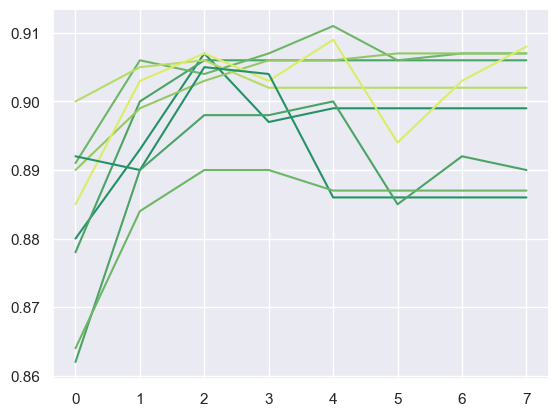

In [113]:
#График обучения, просто чтобы посмотреть, как accuracy менялось
plt.plot(range(max_len), test_accuracy['rnn'][1][100][10])
plt.plot(range(max_len), test_accuracy['rnn'][1][100][25])
plt.plot(range(max_len), test_accuracy['rnn'][1][100][50])
plt.plot(range(max_len), test_accuracy['rnn'][1][256][10])
plt.plot(range(max_len), test_accuracy['rnn'][1][256][25])
plt.plot(range(max_len), test_accuracy['rnn'][1][256][50])
plt.plot(range(max_len), test_accuracy['rnn'][1][1024][10])
plt.plot(range(max_len), test_accuracy['rnn'][1][1024][25])
plt.plot(range(max_len), test_accuracy['rnn'][1][1024][50])

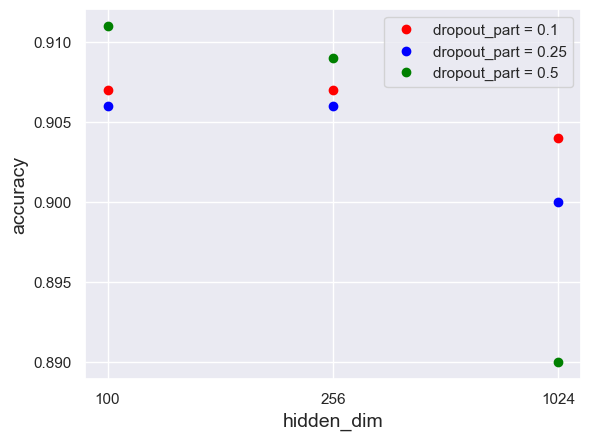

In [114]:
#лучшее качество у моделей
plt.xlabel('hidden_dim', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.xticks(range(3), ['100', '256', '1024'])
plt.plot(range(3), [0.907, 0.907, 0.904], 'o', color = 'r', label = 'dropout_part = 0.1')
plt.plot(range(3), [0.906, 0.906, 0.9], 'o', color = 'b', label = 'dropout_part = 0.25')
plt.plot(range(3), [0.911, 0.909, 0.89], 'o', color = 'g', label = 'dropout_part = 0.5')
plt.legend()
plt.show()

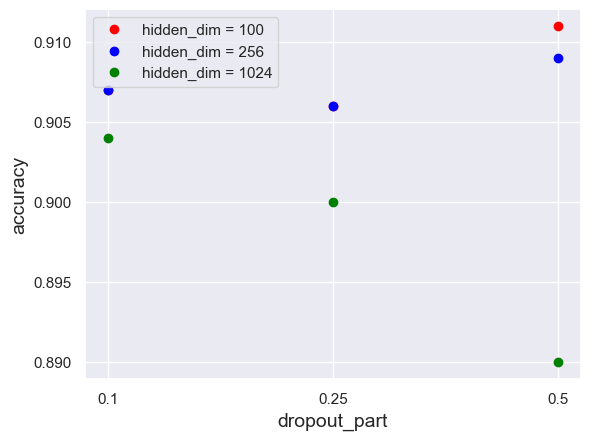

In [115]:
#лучшее качество у моделей, но hidden_dim и dropout_part поменяны местами
plt.xlabel('dropout_part', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.xticks(range(3), ['0.1', '0.25', '0.5'])
plt.plot(range(3), [0.907, 0.906, 0.911], 'o', color = 'r', label = 'hidden_dim = 100')
plt.plot(range(3), [0.907, 0.906, 0.909], 'o', color = 'b', label = 'hidden_dim = 256')
plt.plot(range(3), [0.904, 0.9, 0.89], 'o', color = 'g', label = 'hidden_dim = 1024')
plt.legend()
plt.show()

Видим, что с увеличением hidden_dim качество уменьшается. Но нужно понимать, что модели обучались не всегда до сходимости, а для того, чтобы модель с большим hidden_dim сошлась, нужно больше эпох.

И как раз из-за того, что модель hidden_dim = 1024 dropout_part = 0.5 совсем не сошлась, сильно просело качество, так как большой dropout еще сильнее усложняет процесс обучения.<br>
В итоге можно сказать, что увеличение dropout_part улучшает качество, но замедляет обучение. Так что за оптимальное значение будет взято dropout_part = 0.4. 
hidden_dim слишком большим смысла делать нет, так как время обучения взлетает до небес, но и слишком маленьким тоже делать не стоит, так как мы можем уткнуться в информационный барьер, который не даст нам достичь желаемого качества. За оптимальное значение взято hidden_dim = 256.

Теперь обучим модели большим количеством слоев и с различными модификациями rnn.

In [33]:
#optimal for rnn_1layers
model_rnn_1layers_256hdim_40drop, losses_rnn_1layers_256hdim_40drop, acc_rnn_1layers_256hdim_40drop = start_train(epochs=20, rec_layers=1, hidden_dim=256, dropout_part=0.4, freeze_max_number=3)

* Epoch 1/20
* Train  Epoch accuracy: 0.841658  Epoch loss: 0.443223
* Val    Epoch accuracy: 0.893400  Epoch loss: 0.030132
Saving best model...
* Epoch 2/20
* Train  Epoch accuracy: 0.911300  Epoch loss: 0.268999
* Val    Epoch accuracy: 0.900200  Epoch loss: 0.002060
Saving best model...
* Epoch 3/20
* Train  Epoch accuracy: 0.924850  Epoch loss: 0.225200
* Val    Epoch accuracy: 0.908200  Epoch loss: 0.000801
Saving best model...
* Epoch 4/20
* Train  Epoch accuracy: 0.933425  Epoch loss: 0.196619
* Val    Epoch accuracy: 0.907200  Epoch loss: 0.001752
* Epoch 5/20
* Train  Epoch accuracy: 0.940967  Epoch loss: 0.174868
* Val    Epoch accuracy: 0.910200  Epoch loss: 0.001539
Saving best model...
* Epoch 6/20
* Train  Epoch accuracy: 0.946300  Epoch loss: 0.158170
* Val    Epoch accuracy: 0.903200  Epoch loss: 0.000486
* Epoch 7/20
* Train  Epoch accuracy: 0.951158  Epoch loss: 0.144156
* Val    Epoch accuracy: 0.907400  Epoch loss: 0.000133
* Epoch 8/20
* Train  Epoch accuracy: 0.9

In [34]:
#optimal for rnn_2layers
model_rnn_2layers_256hdim_40drop, losses_rnn_2layers_256hdim_40drop, acc_rnn_2layers_256hdim_40drop = start_train(epochs=20, rec_layers=2, hidden_dim=256, dropout_part=0.4, freeze_max_number=3)

* Epoch 1/20
* Train  Epoch accuracy: 0.834158  Epoch loss: 0.459942
* Val    Epoch accuracy: 0.895200  Epoch loss: 0.004585
Saving best model...
* Epoch 2/20
* Train  Epoch accuracy: 0.908967  Epoch loss: 0.276220
* Val    Epoch accuracy: 0.904000  Epoch loss: 0.003478
Saving best model...
* Epoch 3/20
* Train  Epoch accuracy: 0.923008  Epoch loss: 0.234416
* Val    Epoch accuracy: 0.909400  Epoch loss: 0.166288
Saving best model...
* Epoch 4/20
* Train  Epoch accuracy: 0.931475  Epoch loss: 0.205592
* Val    Epoch accuracy: 0.911600  Epoch loss: 0.001854
Saving best model...
* Epoch 5/20
* Train  Epoch accuracy: 0.938283  Epoch loss: 0.183774
* Val    Epoch accuracy: 0.905800  Epoch loss: 0.000450
* Epoch 6/20
* Train  Epoch accuracy: 0.944608  Epoch loss: 0.166476
* Val    Epoch accuracy: 0.905200  Epoch loss: 0.000679
* Epoch 7/20
* Train  Epoch accuracy: 0.947975  Epoch loss: 0.153754
* Val    Epoch accuracy: 0.904000  Epoch loss: 0.000160
The model is trained


In [40]:
#optimal for rnn_4layers
model_rnn_4layers_256hdim_40drop, losses_rnn_4layers_256hdim_40drop, acc_rnn_4layers_256hdim_40drop = start_train(epochs=20, rec_layers=4, hidden_dim=256, dropout_part=0.4, freeze_max_number=3)

* Epoch 1/20
* Train  Epoch accuracy: 0.813100  Epoch loss: 0.522225
* Val    Epoch accuracy: 0.864400  Epoch loss: 0.020997
Saving best model...
* Epoch 2/20
* Train  Epoch accuracy: 0.894192  Epoch loss: 0.328011
* Val    Epoch accuracy: 0.890800  Epoch loss: 0.003702
Saving best model...
* Epoch 3/20
* Train  Epoch accuracy: 0.908833  Epoch loss: 0.280933
* Val    Epoch accuracy: 0.899800  Epoch loss: 0.051656
Saving best model...
* Epoch 4/20
* Train  Epoch accuracy: 0.916300  Epoch loss: 0.258005
* Val    Epoch accuracy: 0.887000  Epoch loss: 0.138852
* Epoch 5/20
* Train  Epoch accuracy: 0.920967  Epoch loss: 0.242469
* Val    Epoch accuracy: 0.902200  Epoch loss: 0.012625
Saving best model...
* Epoch 6/20
* Train  Epoch accuracy: 0.923983  Epoch loss: 0.233219
* Val    Epoch accuracy: 0.903400  Epoch loss: 0.016887
Saving best model...
* Epoch 7/20
* Train  Epoch accuracy: 0.927667  Epoch loss: 0.220932
* Val    Epoch accuracy: 0.897600  Epoch loss: 0.049332
* Epoch 8/20
* Train

In [43]:
#optimal for gru_1layers
model_gru_1layers_256hdim_40drop, losses_gru_1layers_256hdim_40drop, acc_gru_1layers_256hdim_40drop = start_train(epochs=20, rec_layers=1, hidden_dim=256, dropout_part=0.4, freeze_max_number=3, rnn_type='gru')

* Epoch 1/20
* Train  Epoch accuracy: 0.866908  Epoch loss: 0.377773
* Val    Epoch accuracy: 0.907000  Epoch loss: 0.002289
Saving best model...
* Epoch 2/20
* Train  Epoch accuracy: 0.927900  Epoch loss: 0.215202
* Val    Epoch accuracy: 0.910600  Epoch loss: 0.007066
Saving best model...
* Epoch 3/20
* Train  Epoch accuracy: 0.949258  Epoch loss: 0.151316
* Val    Epoch accuracy: 0.911200  Epoch loss: 0.001895
Saving best model...
* Epoch 4/20
* Train  Epoch accuracy: 0.965750  Epoch loss: 0.103489
* Val    Epoch accuracy: 0.910800  Epoch loss: 0.005018
* Epoch 5/20
* Train  Epoch accuracy: 0.974625  Epoch loss: 0.075396
* Val    Epoch accuracy: 0.907400  Epoch loss: 0.000122
The model is trained


In [44]:
#optimal for gru_2layers
model_gru_2layers_256hdim_40drop, losses_gru_2layers_256hdim_40drop, acc_gru_2layers_256hdim_40drop = start_train(epochs=20, rec_layers=2, hidden_dim=256, dropout_part=0.4, freeze_max_number=3, rnn_type='gru')

* Epoch 1/20
* Train  Epoch accuracy: 0.866450  Epoch loss: 0.378059
* Val    Epoch accuracy: 0.905000  Epoch loss: 0.006086
Saving best model...
* Epoch 2/20
* Train  Epoch accuracy: 0.923892  Epoch loss: 0.224937
* Val    Epoch accuracy: 0.908400  Epoch loss: 0.007816
Saving best model...
* Epoch 3/20
* Train  Epoch accuracy: 0.944333  Epoch loss: 0.163701
* Val    Epoch accuracy: 0.908000  Epoch loss: 0.000654
* Epoch 4/20
* Train  Epoch accuracy: 0.961142  Epoch loss: 0.117170
* Val    Epoch accuracy: 0.905200  Epoch loss: 0.000482
* Epoch 5/20
* Train  Epoch accuracy: 0.969950  Epoch loss: 0.088658
* Val    Epoch accuracy: 0.906000  Epoch loss: 0.000109
The model is trained


In [45]:
#optimal for lstm_1layers
model_lstm_1layers_256hdim_40drop, losses_lstm_1layers_256hdim_40drop, acc_lstm_1layers_256hdim_40drop = start_train(epochs=20, rec_layers=1, hidden_dim=256, dropout_part=0.4, freeze_max_number=3, rnn_type='lstm')

* Epoch 1/20
* Train  Epoch accuracy: 0.871658  Epoch loss: 0.364816
* Val    Epoch accuracy: 0.908600  Epoch loss: 0.008629
Saving best model...
* Epoch 2/20
* Train  Epoch accuracy: 0.929058  Epoch loss: 0.209581
* Val    Epoch accuracy: 0.916800  Epoch loss: 0.003151
Saving best model...
* Epoch 3/20
* Train  Epoch accuracy: 0.950425  Epoch loss: 0.143999
* Val    Epoch accuracy: 0.915400  Epoch loss: 0.008209
* Epoch 4/20
* Train  Epoch accuracy: 0.968775  Epoch loss: 0.091917
* Val    Epoch accuracy: 0.910600  Epoch loss: 0.000127
* Epoch 5/20
* Train  Epoch accuracy: 0.980267  Epoch loss: 0.058135
* Val    Epoch accuracy: 0.908600  Epoch loss: 0.000727
The model is trained


In [72]:
#optimal for lstm_2layers
model_lstm_2layers_256hdim_40drop, losses_lstm_2layers_256hdim_40drop, acc_lstm_2layers_256hdim_40drop = start_train(epochs=20, rec_layers=2, hidden_dim=256, dropout_part=0.4, freeze_max_number=3, rnn_type='lstm')

* Epoch 1/20
* Train  Epoch accuracy: 0.870100  Epoch loss: 0.371411
* Val    Epoch accuracy: 0.909000  Epoch loss: 0.092656
Saving best model...
* Epoch 2/20
* Train  Epoch accuracy: 0.926867  Epoch loss: 0.217035
* Val    Epoch accuracy: 0.915600  Epoch loss: 0.005333
Saving best model...
* Epoch 3/20
* Train  Epoch accuracy: 0.947808  Epoch loss: 0.153585
* Val    Epoch accuracy: 0.914200  Epoch loss: 0.000272
* Epoch 4/20
* Train  Epoch accuracy: 0.965850  Epoch loss: 0.101787
* Val    Epoch accuracy: 0.917200  Epoch loss: 0.000055
Saving best model...
* Epoch 5/20
* Train  Epoch accuracy: 0.977475  Epoch loss: 0.066153
* Val    Epoch accuracy: 0.911600  Epoch loss: 0.000268
* Epoch 6/20
* Train  Epoch accuracy: 0.984467  Epoch loss: 0.047173
* Val    Epoch accuracy: 0.910600  Epoch loss: 0.001178
* Epoch 7/20
* Train  Epoch accuracy: 0.988217  Epoch loss: 0.035372
* Val    Epoch accuracy: 0.909800  Epoch loss: 0.000005
The model is trained


Вот такие резлультаты получились.

In [74]:
best_accuracy = {'rnn': [[0.893, 0.9, 0.908, 0.907, 0.910, 0.903, 0.907, 0.908, 0.906, 0.905],
                         [0.895, 0.904, 0.909, 0.912, 0.906, 0.905, 0.904],
                         [0.864, 0.891, 0.9, 0.887, 0.9, 0.9, 0.898, 0.9, 0.9, 0.897, 0.898]], 
                 'gru': [[0.907, 0.9106, 0.911, 0.911, 0.907],
                         [0.905, 0.908, 0.908, 0.905, 0.906]], 
                 'lstm': [[0.909, 0.917, 0.9154, 0.91, 0.909],
                          [0.909, 0.9156, 0.914, 0.917, 0.9116, 0.9106, 0.91]]}

In [117]:
max_len = 0

for data in best_accuracy['rnn']:
    if len(data) > max_len:
        max_len = len(data)

for data in best_accuracy['rnn']:
    actual_len = len(data)
    data += (max_len - actual_len) * [data[-1]]

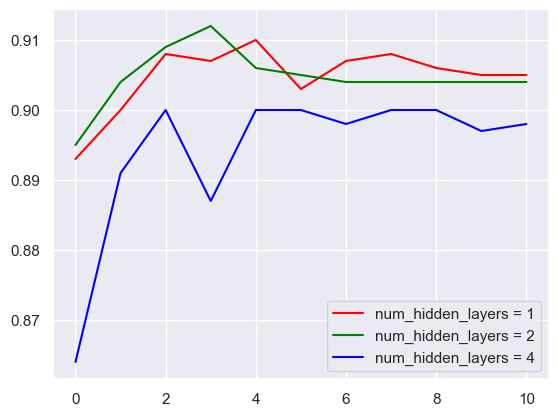

In [126]:
colors = ['r', 'g', 'b']
for i, data in enumerate(best_accuracy['rnn']):
    plt.plot(range(len(data)), data, label =  'num_hidden_layers = ' + str(2**i), color = colors[i])
plt.legend()
plt.show()

Интересно, что с увеличением количества скрытых слоев уменьшается качество. Причем модели обучались до сходимости, то есть дело не в недообученности.<br>
Я думаю, это происходит из-за затухания градиента, что вредит обучению. Модель теряет свою способность запоминать, так как она некачественно заполняет вектор скрытого состояния на первых слоях (так как до туда градиент особо не доходит), тем самым теряя много информации.<br>
Также у меня не получилось обучить модель с 8 скрытыми слоями: при первой попытке обучения все заработало, но при повторных попытках качество почти не сдвигалось с 0.25. Видимо очень важны начальные значения параметров, ведь из-за затухания градиента они слабо меняются.<br>
Думаю, иногда выразительной способности однослойной rnn может не хватить, тогда и можно попытаться увеличить количество слоев, но, опять же, это нужно проверять на деле. Кажется, что не стоит использовать больше 2-3 слоев, из-за затухания градиента и увеличения времени обучения.

In [127]:
max_len = 0

for data in best_accuracy['gru']:
    if len(data) > max_len:
        max_len = len(data)

for data in best_accuracy['gru']:
    actual_len = len(data)
    data += (max_len - actual_len) * [data[-1]]

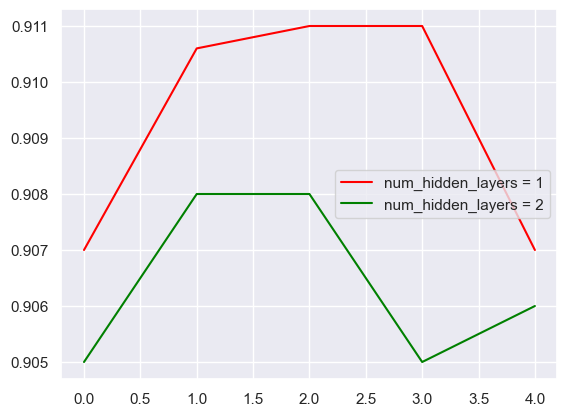

In [129]:
colors = ['r', 'g']
for i, data in enumerate(best_accuracy['gru']):
    plt.plot(range(len(data)), data, label =  'num_hidden_layers = ' + str(i + 1), color = colors[i])
plt.legend()
plt.show()

gru пытается следовать парадигме lstm и не слишком сильно изменять вектор внутреннего состояния, сохраняя часть информации, но при этом gru намного менее мощная, чем lstm и опять имеет проблемы с затуханием градиента, так что качество опять лучше, когда слой только 1.

In [130]:
max_len = 0

for data in best_accuracy['lstm']:
    if len(data) > max_len:
        max_len = len(data)

for data in best_accuracy['lstm']:
    actual_len = len(data)
    data += (max_len - actual_len) * [data[-1]]

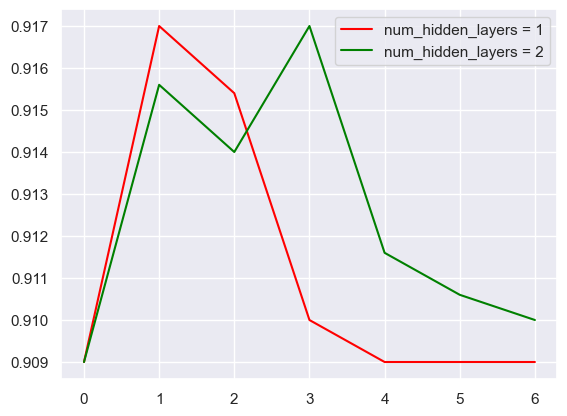

In [131]:
colors = ['r', 'g']
for i, data in enumerate(best_accuracy['lstm']):
    plt.plot(range(len(data)), data, label =  'num_hidden_layers = ' + str(i + 1), color = colors[i])
plt.legend()
plt.show()

А вот здесь ситуация другая. Долгосрочная память помогает меньше забывать более старую информацию, из-за чего решается проблема затухания градиента, так что увеличение количества слоев повышает качество.

В итоге лучшая модель это 
CharLM(hidden_dim=256, vocab_size=len(vocab), num_classes=4, aggregation_type="mean", rec_layers=2, dropout_part=0.4, rnn_type='lstm')